In [155]:
import numpy as np
import matplotlib.pyplot as plt

In [156]:
grid = np.full((10, 10), -0.02)
pos = [(9, 0), (6, 7)]
neg = [(2, 0), (4, 5), (0, 9), (9, 9)]
blockades = [(1, i) for i in range(1, 4)] + [(2, i) for i in range(1, 4)] + [(4, 7), (7, 4), (7, 5), (8, 4), (8, 5)]
print(blockades)
for i, j in pos:
    grid[i, j] = 1.0
for i, j in neg:
    grid[i, j] = -1

print(grid)

[(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (4, 7), (7, 4), (7, 5), (8, 4), (8, 5)]
[[-0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -1.  ]
 [-0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02]
 [-1.   -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02]
 [-0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02]
 [-0.02 -0.02 -0.02 -0.02 -0.02 -1.   -0.02 -0.02 -0.02 -0.02]
 [-0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02]
 [-0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02  1.   -0.02 -0.02]
 [-0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02]
 [-0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02]
 [ 1.   -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -1.  ]]


/tmp/ipykernel_31227/449891358.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')


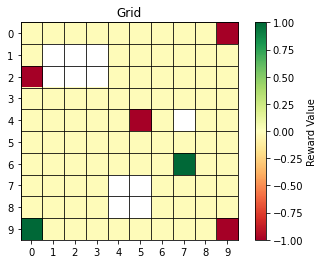

In [157]:
fig, ax = plt.subplots()
im = ax.imshow(grid, cmap='RdYlGn', origin='upper')

block_mask = np.zeros_like(grid, dtype=bool)
for (bi, bj) in blockades:
    block_mask[bi, bj] = True

grid_masked = np.ma.array(grid, mask = block_mask)

ax.set_xticks(range(10))
ax.set_yticks(range(10))

cmap = plt.cm.get_cmap('RdYlGn')
cmap.set_bad('white')

im = ax.imshow(grid_masked, cmap=cmap, origin='upper')

#gridlines on cell boundaries
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='black', linewidth=0.8)
ax.tick_params(which='minor', length=0)

plt.colorbar(im, ax=ax, label='Reward Value')
plt.title("Grid")
plt.show()


In [158]:
'''
p chance of taking random step
Getting to green ends the game
ignore invalid steps
'''

'\np chance of taking random step\nGetting to green ends the game\nignore invalid steps\n'

In [159]:
terminal = np.zeros(grid.shape, dtype=bool)
for (i, j) in pos:
    terminal[i, j] = True

#up, down, left, right
actions = {
    0: (-1, 0),
    1: (1, 0),
    2: (0, -1),
    3: (0, 1)
}
action_names = {0: '↑', 1: '↓', 2: '←', 3: '→'}

p_rand = 0.1
gamma = 0.95 #discount factor
eps = 1e-8 #convergence threshold

H, W = grid.shape
all_actions = list(actions.keys())

In [160]:
def step_from(state, act):
    
    i, j = state
    if terminal[i, j]:
        return {(i, j): 1.0}
    
    def result_of(a):
        di, dj = actions[a]
        ni, nj = i + di, j + dj
        if 0 <= ni < H and 0 <= nj < W and not block_mask[ni, nj]:
            return (ni, nj)
        return None

    valid_results = {a: result_of(a) for a in all_actions if result_of(a) is not None}

    probs = {}
    intended = result_of(act)
    if intended is not None:
        probs[intended] = probs.get(intended, 0.0) + (1 - p_rand)

    
    p_each = p_rand / len(valid_results)
    for out in valid_results.values():
        probs[out] = probs.get(out, 0.0) + p_each

    total = sum(probs.values())
    
    for s in list(probs.keys()):
        probs[s] /= total

    return probs

In [161]:
# precompute transitions probabilities P_sa
transitions = {}  # transition is a dict of dict

for i in range(H):
    for j in range(W):
        transitions[(i, j)] = {}
        if block_mask[i, j]:
            continue
        for a in all_actions:
            transitions[(i, j)][a] = step_from((i, j), a)

V = np.zeros((H, W))
for (i, j) in zip(*np.where(terminal)):
    V[i, j] = grid[i, j]

iteration = 0
while True:
    delta = 0.0
    iteration += 1
    V_old = V.copy()
    for i in range(H):
        for j in range(W):
            # skip terminal and blockade cells
            if terminal[i, j] or block_mask[i, j]:
                continue
            best = -np.inf
            for a in all_actions:
                trans = transitions.get((i, j), {}).get(a)
                if not trans:
                    continue
                total = 0.0
                for (ni, nj), p in trans.items():
                    r = grid[ni, nj]
                    if terminal[ni, nj]:
                        total += p * r
                    else:
                        total += p * (r + gamma * V_old[ni, nj])
                if total > best:
                    best = total
            V[i, j] = best
            delta = max(delta, abs(V[i, j] - V_old[i, j]))
    if delta < eps:
        break

print(f"Value iteration converged in {iteration} iterations")

Value iteration converged in 37 iterations


In [162]:
policy = np.full((H, W), None, dtype=object)

for i in range(H):
    for j in range(W):
        if terminal[i, j] or block_mask[i, j]:
            policy[i, j] = None
            continue

        best_a = None
        best_q = -np.inf
        for a in all_actions:
            # skip actions that would move off-grid (invalid intended action)
            di, dj = actions[a]
            ni, nj = i + di, j + dj
            if not (0 <= ni < H and 0 <= nj < W):
                continue

            q = 0.0
            for (si, sj), p in transitions[(i, j)][a].items():
                r = grid[si, sj]
                if terminal[si, sj]:
                    q += p * r
                else:
                    q += p * (r + gamma * V[si, sj])
            if q > best_q:
                best_q = q
                best_a = a

        policy[i, j] = best_a

/tmp/ipykernel_31227/1202423733.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')


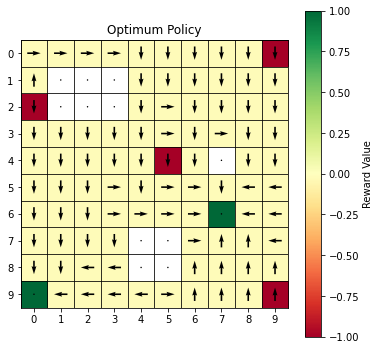

In [163]:

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(grid, cmap='RdYlGn', origin='upper')

# ticks at centers and gridlines on boundaries
ax.set_xticks(np.arange(W))
ax.set_yticks(np.arange(H))
ax.set_xticks(np.arange(-0.5, W, 1), minor=True)
ax.set_yticks(np.arange(-0.5, H, 1), minor=True)
ax.grid(which='minor', color='black', linewidth=0.8)
ax.tick_params(which='minor', length=0)

# build arrow field
X, Y = np.meshgrid(np.arange(W), np.arange(H))
DX = np.zeros((H, W), dtype=float)
DY = np.zeros((H, W), dtype=float)

for i in range(H):
    for j in range(W):
        a = policy[i, j]
        if a is None:
            DX[i, j] = 0
            DY[i, j] = 0
            continue
        di, dj = actions[a]
        DX[i, j] = dj
        DY[i, j] = di 

cmap = plt.cm.get_cmap('RdYlGn')
cmap.set_bad('white')

im = ax.imshow(grid_masked, cmap=cmap, origin='upper')

ax.quiver(X, Y, DX, DY, angles='xy', scale_units='xy', scale=2, pivot='middle', color='k')

ax.set_aspect('equal')
plt.colorbar(im, ax=ax, label='Reward Value')
ax.set_title("Optimum Policy")
plt.show()

In [164]:
for i in range(H):
    row = []
    for j in range(W):
        if block_mask[i, j]:
            row.append("  X   ")
        elif terminal[i, j]:
            row.append("  T   ")
        else:
            row.append(f"{V[i, j]:6.3f}")
    print(" ".join(row))

 0.285  0.327  0.369  0.414  0.461  0.503  0.552  0.537  0.544  0.513
 0.213   X      X      X     0.510  0.554  0.608  0.589  0.635  0.562
 0.534   X      X      X     0.562  0.609  0.668  0.645  0.700  0.653
 0.602  0.590  0.546  0.584  0.616  0.647  0.733  0.704  0.767  0.714
 0.699  0.647  0.597  0.640  0.675  0.746  0.802   X     0.839  0.777
 0.766  0.708  0.652  0.701  0.765  0.814  0.912  0.990  0.913  0.843
 0.836  0.772  0.711  0.763  0.834  0.909  0.988   T     0.988  0.910
 0.911  0.841  0.773  0.716   X      X     0.914  0.988  0.912  0.841
 0.990  0.913  0.841  0.775   X      X     0.844  0.908  0.838  0.741
  T     0.990  0.911  0.836  0.769  0.718  0.778  0.833  0.738  0.684
